<a href="https://colab.research.google.com/github/Dhirajdgandhi/AI-Based-Assistance-Using-Pose-Estimations-and-Activity-Recognition/blob/main/Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U kora

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 


In [ ]:
import os
# from keras.applications import ResNet101
import cv2
import numpy as np
# from scipy import spatial
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import json 
from google.colab.patches import cv2_imshow
from collections import Counter

# from keras.models import Sequential, Model, load_model
# from keras.layers import Dense, Dropout, Flatten, Multiply, LSTM, Concatenate, Bidirectional, Add, Reshape
# from keras import Input
# from keras.losses import SparseCategoricalCrossentropy
# from keras.utils.vis_utils import plot_model
# from keras.utils import to_categorical
# from keras.callbacks import ModelCheckpoint

from kora.drive import upload_public


In [ ]:
DATASET_DIR = "Dataset"

In [ ]:
# Load the Drive helper and mount. You will have to authorize this operation. 
from google.colab import drive
drive.mount('/content/drive')
DRIVE_DIR = "/content/drive/My Drive/Advance CV/Term Project"
os.chdir(DRIVE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/zh-plus/video-to-pose3D.git

Cloning into 'video-to-pose3D'...
remote: Enumerating objects: 1247, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 1247 (delta 1), reused 2 (delta 0), pack-reused 1237
Receiving objects: 100% (1247/1247), 11.46 MiB | 8.47 MiB/s, done.
Resolving deltas: 100% (604/604), done.
Checking out files: 100% (483/483), done.


In [ ]:
os.chdir("video-to-pose3D")

In [ ]:
os.chdir(DRIVE_DIR)

In [ ]:
FILE_NAME = "punches.mp4"

In [ ]:
# please update file name in this file explicitly
!python videopose.py

the video is 30.0 f/s
Loading YOLO model..
Loading pose model from joints_detectors/Alphapose/models/sppe/duc_se.pth
Start pose estimation...
100% 313/313 [00:22<00:00, 13.83it/s]
===========================> Rendering remaining images in the queue...
===========================> If this step takes too long, you can enable the --vis_fast flag to use fast rendering (real-time).
kpts npz save in  outputs/alpha_pose_elbow4/elbow4.npz
-------------- load data spends 32.68 seconds
Loading checkpoint checkpoint/pretrained_h36m_detectron_coco.bin
-------------- load 3D model spends 0.08 seconds
Rendering...
-------------- generate reconstruction 3D data spends 0.03 seconds
===========================> This video get 313 frames in total.
314it [00:47,  6.56it/s]
total spend 49.604401 second
../Dataset/elbow4.mp4 --- elapsed time: 82.39554813200084 s


### Confidence values for joints
We are not using this 

In [ ]:
outfile_conf = pd.read_json(f"outputs/alpha_pose_{FILE_NAME[:-4]}/alphapose-results.json")
points_conf = np.array(outfile_3d['keypoints'][0]).reshape(-1,3)
points_conf

array([[635.40930176, 203.07565308,   0.91237116],
       [643.21588135, 195.26907349,   0.91507185],
       [627.60272217, 195.26907349,   0.93993825],
       [654.92572021, 203.07565308,   0.92009807],
       [615.8928833 , 203.07565308,   0.86626089],
       [670.53887939, 257.72167969,   0.87274981],
       [600.27972412, 257.72167969,   0.846632  ],
       [717.37835693, 316.27102661,   0.9256469 ],
       [553.44024658, 316.27102661,   0.93683767],
       [697.86187744, 378.72363281,   0.87102461],
       [572.95672607, 378.72363281,   0.85843372],
       [662.7322998 , 390.43347168,   0.76770496],
       [608.08630371, 390.43347168,   0.77129459],
       [678.34545898, 499.7255249 ,   0.8956058 ],
       [592.47314453, 499.7255249 ,   0.89088154],
       [693.95861816, 612.92089844,   0.82585835],
       [576.85998535, 612.92089844,   0.83675182]])

### Extract keypoints from saved file

In [ ]:
outfile = f"outputs/alpha_pose_{FILE_NAME[:-4]}/{FILE_NAME[:-4]}.npz"

import numpy as np
npzfile = np.load(outfile)
npzfile.files

['kpts']

In [ ]:
key_points =  npzfile['kpts']
n_frames, n_joints, n_dim = key_points.shape
n_frames, n_joints, n_dim

(303, 17, 2)

Trimming Ground Truth Video to Match Test Video

In [ ]:
ground_truth_points = key_points
ground_truth_points.shape # xy coods
ground_truth_points_old = np.copy(ground_truth_points)

ground_truth_points = ground_truth_points[:test_points.shape[0],:,:]
ground_truth_points.shape

(303, 17, 2)

In [ ]:
# test_points = key_points[:ground_truth_points.shape[0],:,:]
test_points = key_points
test_points.shape # xy coods

(327, 17, 2)

...Finished trimming

In [ ]:
import cv2

class video_reader():
  def __init__(self, filename):
    self.cap = cv2.VideoCapture(f"../Dataset/{filename}")
    self.nframes = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
    self.fps = self.cap.get(cv2.CAP_PROP_FPS)
    self.w = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    self.h = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f"type=video fps={self.fps} width={self.w} height={self.h}")

reader = video_reader(FILE_NAME)

type=video fps=30.0 width=1280 height=720


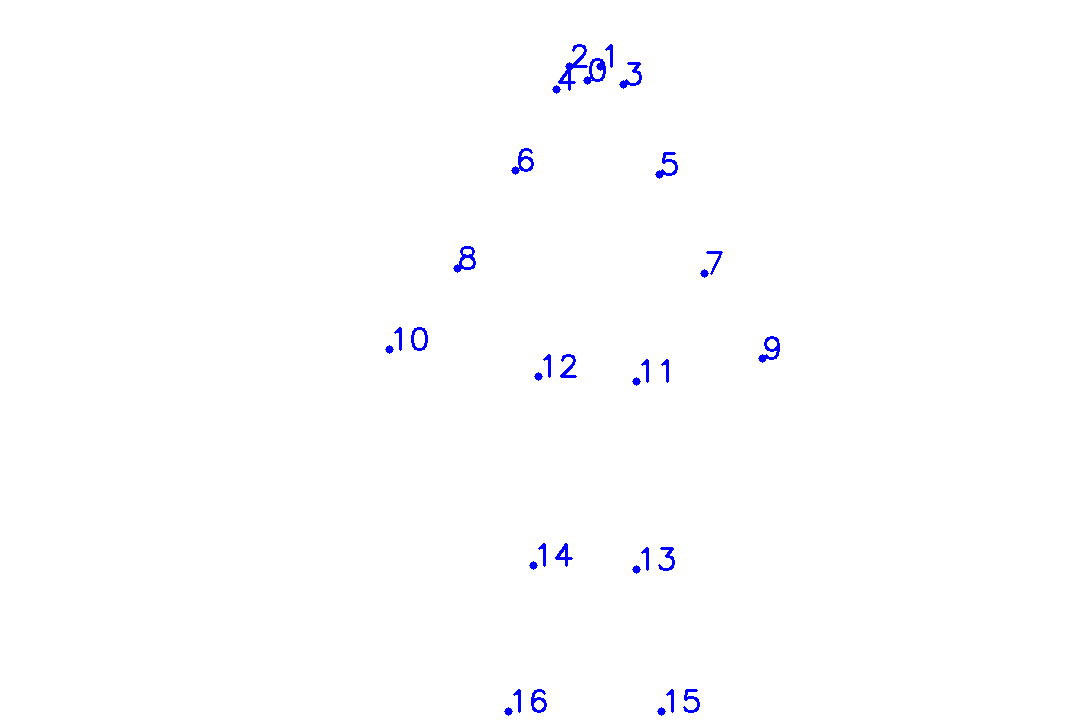

In [ ]:
from google.colab.patches import cv2_imshow

image = np.ones((reader.h, reader.w, 3))
image = image*255
for index,(x,y) in enumerate(ground_truth_points[0]):
  cv2.putText(image, str(index) , (int(x),int(y)), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255, 0, 0), 2, cv2.LINE_AA)
  cv2.circle(image, (int(x),int(y)), 4, (255, 0, 0), -1)

cv2_imshow(image)

type=video fps=30.0 width=1280 height=720


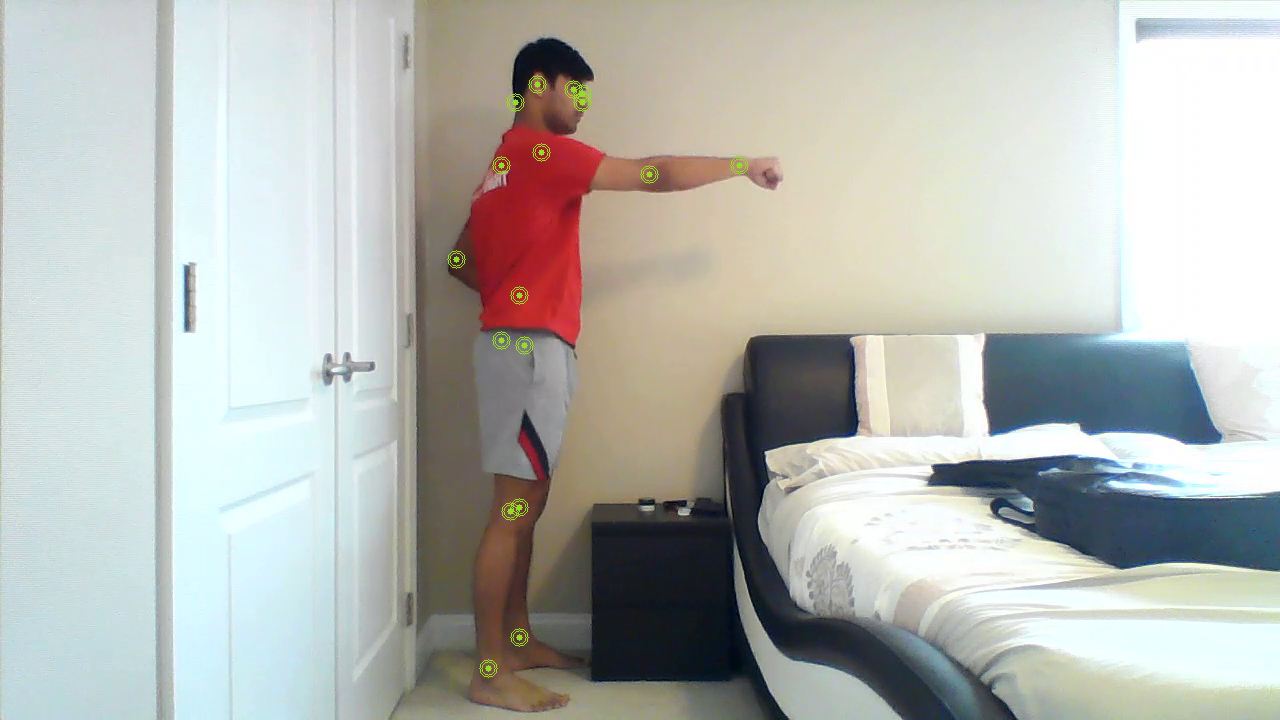

In [ ]:
from google.colab.patches import cv2_imshow

frame_num = 80

reader = video_reader(FILE_NAME)
i = 0

while(1):
  ret, image = reader.cap.read()

  if not ret or i==frame_num:
    break
  
  i+=1


# image = np.ones((reader.h, reader.w, 3))
# image = image*255

WHITE = (255,255,255)
YELLOW_COLOR = (0, 255, 255)
GREEN_COLOR = (0, 255, 255)
RED_COLOR = (0,0, 255)
ORANGE_COLOR = (0,165,255)

COLOR = (42, 219, 151)

def hey(orig_img, i, text, value, color=(255,255,255)):
  angle_indicator_text = str(f"{text} : {value}")
  cv2.rectangle(orig_img, (0, 100+i*50), (400, 150+i*50), (42, 219, 151), cv2.FILLED )
  cv2.putText(orig_img, angle_indicator_text, (50, 100+i*50+25), cv2.FONT_HERSHEY_DUPLEX, 1.0, color, 1)


for index,(x,y) in enumerate(ground_truth_points[frame_num]):
  
  # cv2.putText(image, str(index) , (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,128,0), 2, cv2.LINE_AA)

  color = COLOR
  # if index == 6 or index == 8 or index ==10:
    # color = RED_COLOR
  # elif index == 15 or index == 16 or index == 12 or index == 11:
  #   color = ORANGE_COLOR

  # color = YELLOW_COLOR
  # x1, y1 = get_reference_torso(test_points[frame_num])

  cv2.circle(image, (int(x), int(y)), 3, color, -1)
  cv2.circle(image, (int(x), int(y)), 7, color, 1)
  cv2.circle(image, (int(x), int(y)), 9, color, 1)

  # hey(image, 0, "Knees", "PERFECT", WHITE)
  # hey(image, 1, "Dist.", "PERFECT", WHITE)
  # hey(image, 2, "Ankles", "PERFECT", WHITE)
  # hey(image, 3, "Arm Angle", "CAUTION", RED_COLOR)

  # kpts = test_points[frame_num]
  # x2, y2 = ((kpts[15][0] + kpts[16][0])//2, (kpts[15][1] + kpts[16][1])//2)
  # cv2.circle(image, (int(x2), int(y2)), 3, COLOR, -1)
  # cv2.circle(image, (int(x2), int(y2)), 7, COLOR, 1)
  # cv2.circle(image, (int(x2), int(y2)), 9, COLOR, 1)

cv2_imshow(image)

# Normalize joints using the Torso Diameter

## Get Torso Diameter
Distance between the left shoulder and the right hip.
This is used to normlaize the joints to compare with the ground truth

In [ ]:
import math 

def get_torso_diameter(kpts):
  # for index,  (x,y) in enumerate(zip(kpts_order, kpts)):
  ls_x, ls_y = kpts[5] # left shoulder
  rh_x, rh_y = kpts[12] # right hip

  return math.sqrt((ls_x - rh_x)**2 + (ls_y - rh_y)**2)

Normalize points using torso diameter for every frame

In [ ]:
def normalize_kpts(kpts):
  normalized_test_points = []

  for kpt in kpts:
    torso_diam = get_torso_diameter(kpt)
    frac = 150/torso_diam # Scale up by x (here = 150) as well

    newkpts = []
    for x,y in kpt:
      x = int(x*frac)
      y = int(y*frac)

      newkpts.append((x,y))

    normalized_test_points.append(newkpts)
  
  return normalized_test_points

In [ ]:
normalized_ground_truth_points = normalize_kpts(ground_truth_points)
normalized_test_points = normalize_kpts(test_points)

# torso_diam_ground_truth, torso_diam_test

## Align Ground Truth and User Video
Use bottom torso points to align
Make sure videos have starting frame poses matched.

In [ ]:
def get_reference_torso(kpts):
  ref_bottom_torso = ((kpts[11][0] + kpts[12][0])//2, (kpts[11][1] + kpts[12][1])//2)

  return ref_bottom_torso

Modify test points to align with reference points

In [ ]:
modified_test_points = []

for kpts, refkpts in zip(normalized_test_points, normalized_ground_truth_points):
  frame_keypoints = []

  ''' get bottom torso points '''
  test_x, test_y = get_reference_torso(kpts)  
  refx, refy = get_reference_torso(refkpts)

  dx = test_x - refx
  dy = test_y - refy

  for x,y in kpts:

    x -= dx
    y -= dy

    frame_keypoints.append((x,y)) 
  
  modified_test_points.append(frame_keypoints)


Superimpose both test points and modified test points to see the difference

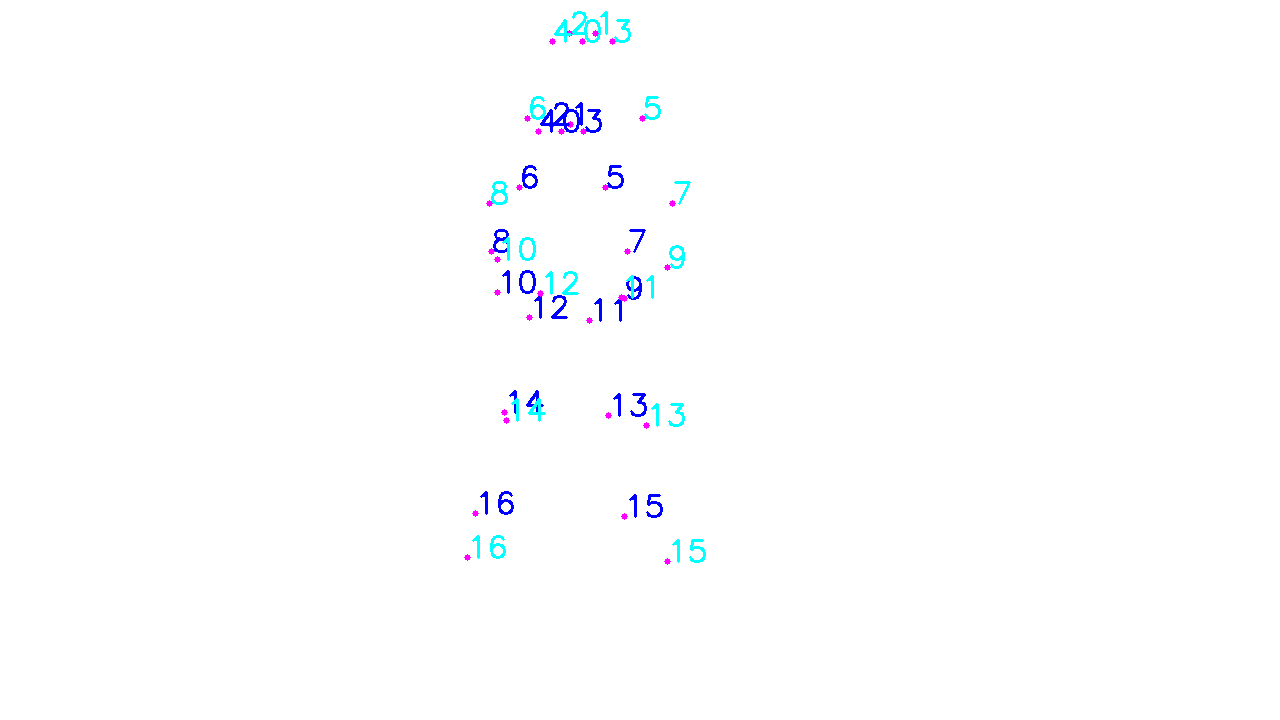

In [ ]:
from google.colab.patches import cv2_imshow

image = np.ones((reader.h, reader.w, 3))
image = image*255
for index, ((orgx, orgy) ,(x,y)) in enumerate(zip(test_points[0],modified_test_points[0])):
  cv2.putText(image, str(index) , (x,y), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255, 0, 0), 2, cv2.LINE_AA)
  cv2.circle(image, (x, y), 3, (255, 0, 255), -1)


  cv2.putText(image, str(index) , (orgx,orgy), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (255, 255, 0), 2, cv2.LINE_AA)
  cv2.circle(image, (orgx,orgy), 3, (255, 0, 255), -1)

cv2_imshow(image)

....Successful Alignment

# LSTM for action classification

In [ ]:
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.models import load_model
from keras.utils import to_categorical

In [ ]:
def get_x_y_points(filename, label):
  outfile = f"outputs/alpha_pose_{filename[:-4]}/{filename[:-4]}.npz"
  npzfile = np.load(outfile)

  key_points =  npzfile['kpts']
  n_frames, n_joints, n_dim = key_points.shape

  if n_frames < 210:
    return
  # test_points = key_points[:ground_truth_points.shape[0],:,:]
  tp = key_points[:200, :, :]
  tp = tp.reshape(200, -1)
  return tp, label

In [ ]:
files = ["squats_girl.mp4", "squat6.mp4", "armcurls3.mp4", "elbow2.mp4", "fittuber.mp4", "squat3.mp4", "squat10.mp4", "squat4.mp4", "punches.mp4", "elbow3.mp4", "squat8.mp4", "squat12.mp4", "windmill.mp4", "squats_girl.mp4", "armcurls1.mp4", "bird_dog.mp4", "squat3.mp4", "squat4.mp4", "imperfect_squats_Dhiraj.mp4", "windmill.mp4"]
labels = [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0]
labels = to_categorical(labels)

x_train, y_train = [], []
for filename, label in zip(files, labels):

  try:
    x, y = get_x_y_points(filename, label)
  except:
    continue

  x_train.append(x)
  y_train.append(y)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
test_files = ["squat5.mp4", "squat7.mp4", "elbow1.mp4", "squat11.mp4", "armcurls2.mp4", "elbow4.mp4", "squat9.mp4"]
test_labels = [1, 1, 0, 1, 0, 0, 1]
test_labels = to_categorical(test_labels)

x_test, y_test = [], []
for filename, label in zip(test_files, test_labels):

  try:
    x, y = get_x_y_points(filename, label)
  except:
    continue

  x_test.append(x)
  y_test.append(y)

x_test = np.arr ay(x_test)
y_test = np.array(y_test)

In [ ]:
def train_LSTM(X_train, Y_train, X_test, Y_test, NAME, label_output):
  model = Sequential()
  model.add(LSTM(128, input_shape=(X_train.shape[1:]), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(LSTM(128, return_sequences=True))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())

  model.add(LSTM(128))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())


  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(label_output, activation='sigmoid'))


  EPOCHS = 200
  BATCH_SIZE = 32
  lr = 0.001
  ro = 0.9
  opt = tf.keras.optimizers.RMSprop(learning_rate=lr, rho=ro)
  model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
  )
  filepath = "LSTM-{epoch:02d}-{val_acc:.3f}"

  history = model.fit(
    X_train, Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, Y_test),
    shuffle=True,
  )

  score = model.evaluate(X_test, Y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(f'Learning Rate {lr}, Rho {ro}')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  # plt.savefig(f"accuracy_lr{lr}rho{ro}.png")
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(f'Learning Rate {lr}, Rho {ro}')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  # plt.savefig(f"loss_lr{lr}rho{ro}.png")
  plt.show()

  model.save("{}.h5".format(NAME))

Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 1.2511 - accuracy: 0.5000 - val_loss: 0.6334 - val_accuracy: 0.5714
Epoch 2/200
1/1 [==============================] - 0s 83ms/step - loss: 0.9064 - accuracy: 0.6000 - val_loss: 0.6508 - val_accuracy: 0.5714
Epoch 3/200
1/1 [==============================] - 0s 83ms/step - loss: 0.4224 - accuracy: 0.8500 - val_loss: 0.6338 - val_accuracy: 0.5714
Epoch 4/200
1/1 [==============================] - 0s 81ms/step - loss: 0.7077 - accuracy: 0.7000 - val_loss: 0.6741 - val_accuracy: 0.5714
Epoch 5/200
1/1 [==============================] - 0s 89ms/step - loss: 0.5300 - accuracy: 0.8000 - val_loss: 0.6468 - val_accuracy: 0.5714
Epoch 6/200
1/1 [==============================] - 0s 82ms/step - loss: 0.1636 - accuracy: 0.9500 - val_loss: 0.6262 - val_accuracy: 0.5714
Epoch 7/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0456 - accuracy: 1.0000 - val_loss: 0.6160 - val_accuracy: 0.5714
Epoch 8/200
1/1 [=====

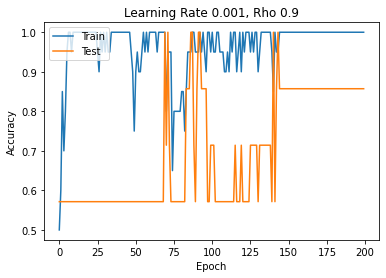

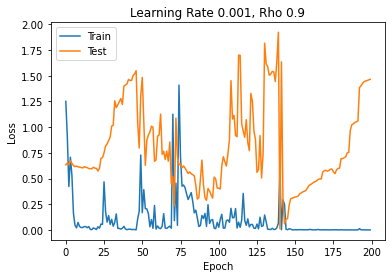

In [ ]:
train_LSTM(x_train, y_train, x_test, y_test, "bigger_dataset_plot", len(y_train[0]))

In [ ]:
model = load_model("bigger_dataset_plot.h5")

In [ ]:
prediction = model.predict(x_train)

In [ ]:
print(np.argmax(prediction, axis = 1), np.argmax(y_train, axis = 1))

[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0] [1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0]


In [ ]:
test_prediction = model.predict(x_test)
print(np.argmax(test_prediction, axis = 1), np.argmax(y_test, axis = 1))

[1 1 1 1 1 1 1] [1 1 0 1 0 0 1]


## Helper 

In [ ]:
def draw_angle_indicator(orig_img, angle, text, i):
  angle_indicator_text = str(f"{text} : {angle}")
  cv2.rectangle(orig_img, (0, 100+i*50), (400, 150+i*50), (42, 219, 151), cv2.FILLED )
  cv2.putText(orig_img, angle_indicator_text, (50, 100+i*50+25), cv2.FONT_HERSHEY_DUPLEX, 1.0, (255, 255, 255), 1)

def getslope(p1,p2):
  if (p1[0]-p2[0]) == 0:
    return 0

  return (p1[1]-p2[1])/(p1[0]-p2[0])

def get_angle(P1,P2,P3):
  # Use tan formula for angle
  m1 = getslope(P1, P2)
  m2 = getslope(P2, P3)

  if m1*m2 == -1:
    return 90

  angle = math.atan(abs((m1-m2)/(1+m1*m2)))
  return round(math.degrees(angle))

def get_distance(P1, P2):
  x1, y1 = P1
  x2, y2 = P2
  return round(math.sqrt((x1 - x2)**2 + (y1 - y2)**2))

def get_reference_ankles(kpts):
  ref_ankles = ((kpts[15][0] + kpts[16][0])//2, (kpts[15][1] + kpts[16][1])//2)
  return ref_ankles

## Superimpose

In [ ]:
kpts_order = {'nose':0, 'left_eye':1, 'right_eye':2, 'left_ear':3, 'right_ear':4, 'left_shoulder':5,'right_shoulder':6, 'left_elbow':7, 'right_elbow':8, 'left_wrist':9, 'right_wrist':10, 'left_hip':11, 'right_hip':12, 'left_knee':13, 'right_knee':14, 'left_ankle':15, 'right_ankle':16}

Define all parameters

In [ ]:
def check_and_print_error(image, body_part_estimation, ground_truth, body_part, text_number, error_percentage):
  delta = error_percentage * ground_truth

  if ground_truth - delta <= body_part_estimation <= ground_truth + delta:
      draw_angle_indicator(image, body_part_estimation, f"{body_part} GREAT", text_number)
  else:
    if body_part_estimation > 0:
      if ground_truth + delta < body_part_estimation <= (ground_truth + delta*2):
        text = f"{body_part} OK - Closer"
      elif (ground_truth + delta*2) < body_part_estimation <= (ground_truth + delta*3):
        text = f"{body_part} BAD - Closer"
      else:
        text = f"{body_part} WRONG - Closer"
      draw_angle_indicator(image, body_part_estimation, text, text_number)
    else:
      if (ground_truth - 2*delta) < body_part_estimation <= ground_truth - delta:
        text = f"{body_part} OK - Spread"
      elif (ground_truth - 3*delta) < body_part_estimation <= (ground_truth - 0.5*delta):
        text = f"{body_part} BAD - Spread"
      else:
        text = f"{body_part} WRONG - Spread"
      draw_angle_indicator(image, body_part_estimation, text, text_number)

In [ ]:
def define_parameters_and_calculate(kpts, image, isTrain, iter):
  angle_left_hand = get_angle(kpts[5], kpts[7], kpts[9])
 
  # To get distance between torso and ground
  torso_points = get_reference_torso(kpts)
  ankle_points = get_reference_ankles(kpts)
  torso_ground_distance = get_distance(torso_points, ankle_points)
  
  # Getting ankle distance
  ankle_distance = get_distance(kpts[15], kpts[16])
  
  # Getting knees distance
  knees_distance = get_distance(kpts[13], kpts[14])
  
  # draw_angle_indicator(image, angle_left_hand, "LHS deg", 0)
  # draw_angle_indicator(image, torso_ground_distance, "TG", 1)
  # draw_angle_indicator(image, ankle_distance, "ANK", 2)
  # draw_angle_indicator(image, knees_distance, "KNEES", 3)

  if isTrain:
    angles_left_hand.append(angle_left_hand)
    torso_ground_distances.append(torso_ground_distance)
    ankle_distances.append(ankle_distance)
    knees_distances.append(knees_distance)
  else:
    # angle_left_hand -= angles_left_hand[iter]
    # torso_ground_distance -= torso_ground_distances[iter]
    # ankle_distance -= ankle_distances[iter]
    # knees_distance -= knees_distances[iter]

    angle_left_hand = round(angle_left_hand)
    torso_ground_distance = round(torso_ground_distance)
    ankle_distance = round(ankle_distance)
    knees_distance = round(knees_distance)

    # draw_angle_indicator(image, angle_left_hand, "LHS deg diff", 4)
    # draw_angle_indicator(image, torso_ground_distance, "TG diff", 5)
    # draw_angle_indicator(image, ankle_distance, "ANK diff", 6)
    # draw_angle_indicator(image, knees_distance, "KNEES diff", 7)

    check_and_print_error(image, angle_left_hand, angles_left_hand[iter], "Hands", 0, 0.25)
    check_and_print_error(image, torso_ground_distance, torso_ground_distances[iter], "Distance", 1, 0.25)
    check_and_print_error(image, ankle_distance, ankle_distances[iter], "Ankle", 3, 0.25)
    check_and_print_error(image, knees_distance, knees_distances[iter], "Knees", 4, 0.25)

    # if knees_distance_error[0] < knees_distance < knees_distance_error[1]:
    #   draw_angle_indicator(image, knees_distance, "Perfect knees movement", 7)
    # else:
    #   if knees_distance > 0:
    #     draw_angle_indicator(image, knees_distance, "Bring your knees closer", 7)
    #   else:
    #     draw_angle_indicator(image, knees_distance, "Spread your knees", 7)

In [ ]:
from google.colab.patches import cv2_imshow
import math 

ERROR_FRACTION = 0.2

def superimpose(ground_truth_points, test_points, image=None, isTrain=True, iter=0):
  image = np.ones((reader.h, reader.w, 3))
  image = image*255

  # total_error = 0

  # torso_diam = get_torso_diameter(ground_truth_points)
  # error_circle_radius = ERROR_FRACTION * torso_diam

  for index, ((x1,y1), (x2,y2)) in enumerate(zip(ground_truth_points, test_points)):
    # cv2.circle(image, (x1, y1), int(error_circle_radius) , (0, 255, 0), 1)
    
    # if index == 5 or index==7 or index == 9: # left hand
    if isTrain:
      cv2.circle(image, (x1, y1), 4, (0, 255, 0), -1)
    else:
      cv2.circle(image, (x2, y2), 4, (255, 0, 0), -1)
    # elif index == 6 or index==8 or index == 10: # right hand
    # cv2.circle(image, (x1, y1), 4, (0, 255, 255), -1)
    # cv2.circle(image, (x2, y2), 4, (255, 0, 255), -1)
  
  if isTrain:
    define_parameters_and_calculate(ground_truth_points, image, isTrain, iter)
  else:
    define_parameters_and_calculate(test_points, image, isTrain, iter)

  # error = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

  # image = cv2.line(image, (x1, y1), (x2, y2), (0,0,255), 1)

  return np.uint8(image)
  # cv2_imshow(image)

In [ ]:
CODEC_fourcc = 'XVID'
# make sure you change the name of the filename everytime you save it on gdrive
video_filepath = f'../Dataset/{FILE_NAME[:-4]}_superimposed_aligned_normalzied_4.mp4'
# video_filepath = f'../Dataset/{FILE_NAME[:-4]}_editing.mp4'

if os.path.exists(video_filepath):
  os.remove(video_filepath)
  print("File removed")

In [ ]:
# read Test Video again
reader = video_reader(FILE_NAME)
# reader = video_reader("squats_girl.mp4")

type=video fps=30.0 width=1280 height=720


Loading Ground Truth Parameters

In [ ]:
isTrain = True

angles_left_hand = []
torso_ground_distances = []
ankle_distances = []
knees_distances = []

In [ ]:
isTrain = False

angles_left_hand, torso_ground_distances, ankle_distances, knees_distances = np.load("params.npy")

In [ ]:
error_video = cv2.VideoWriter(video_filepath, cv2.VideoWriter_fourcc(*CODEC_fourcc), reader.fps, (reader.w, reader.h))

i=0

# ret, frame = reader.cap.read()
  # if ret == False or j >= len(angles_left_hand):
  #   break

# while(1):
for j in range(303):

  frame = superimpose(ground_truth_points[j], test_points[j], image=None, isTrain=isTrain, iter=j)
  # try:
  error_video.write(frame)
  # except:
  #   print("Error")
  # cv2_imshow(frame)
  # break
  # i+=1

if error_video:
  print(f"Processed {j} frames")
  error_video.release()

# reader.cap.release()

Processed 302 frames


Saving all ground truth parameters

In [ ]:
np.save("punches_params.npy", [angles_left_hand, torso_ground_distances, ankle_distances, knees_distances])

In [ ]:
angles_left_hand.shape

AttributeError: ignored

## Play video

In [ ]:
url = upload_public(f'../Dataset/{FILE_NAME[:-4]}_superimposed_aligned_normalzied_17.mp4')
# then display it
from IPython.display import HTML
HTML(f"""<video src={url} width=500 controls/>""")

# Neural Network for Activity Score